## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [58]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize

import warnings

warnings.filterwarnings(action="ignore", category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Random state seed
rseed = 42

## Load and explore data

In [38]:
# Import the dataset
dataset = pd.read_csv("Country-data.csv")

In [39]:
# Check the shape
dataset.shape

(167, 10)

In [40]:
# Check datatypes & counts
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [41]:
# Get descriptive statistics
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
dataset.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [42]:
# Identify any missing data

# Iterating through the dataset columns
for column in dataset.columns:
    # Calculating the nan rate in each column by
    # Counting the number of nan data points and dividing the number to the total number of rows in the dataset
    column_nan_rate = (dataset[column].isna().sum() / dataset.shape[0]) * 100
    # Printing the nan rate
    print("Nan rate in {} column: %{}".format(column, column_nan_rate))

Nan rate in country column: %0.0
Nan rate in child_mort column: %0.0
Nan rate in exports column: %0.0
Nan rate in health column: %0.0
Nan rate in imports column: %0.0
Nan rate in income column: %0.0
Nan rate in inflation column: %0.0
Nan rate in life_expec column: %0.0
Nan rate in total_fer column: %0.0
Nan rate in gdpp column: %0.0


## Preprocessing and Feature Selection

In [43]:
# Drop any non-numeric features (columns)

# The only column of type of object, is the 'country' column
dataset.drop("country", axis=1, inplace=True)

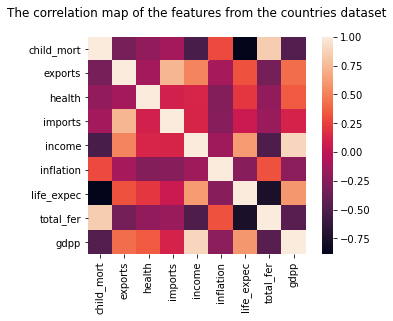

In [44]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
# https://www.w3schools.com/datascience/ds_stat_correlation_matrix.asp
correlation_matrix = dataset.corr()

htmp = sns.heatmap(data=correlation_matrix, square=True)

# https://www.geeksforgeeks.org/how-to-adjust-title-position-in-matplotlib/
plt.title("The correlation map of the features from the countries dataset", pad=20)
plt.show()

Based on the correlation map, the most correlated features to the 'gdpp' feature, are:
- 'income'
- 'life_expec'
- 'exports'
- 'health'

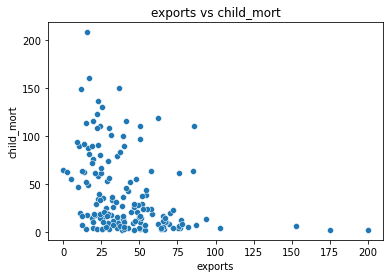

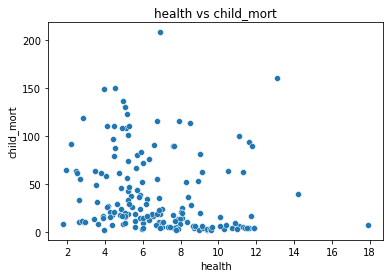

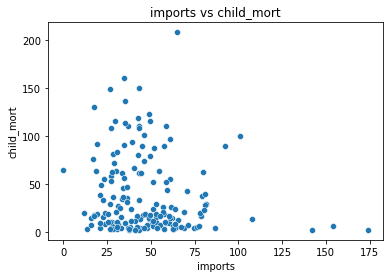

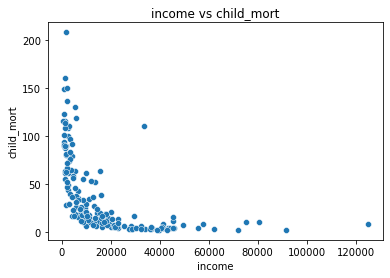

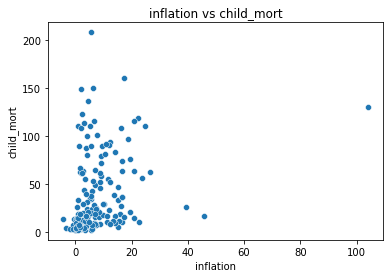

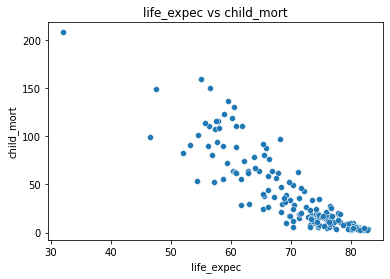

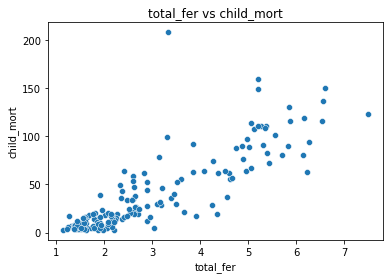

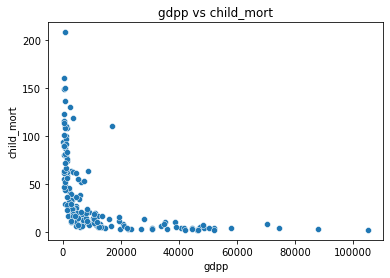

In [367]:
# Explore the continuous independent features against child_mort using scatter plots.
for column in dataset.columns:
    if column != "child_mort":
        fig, ax = plt.subplots(1, 1)
        sns.scatterplot(data=dataset, x=column, y="child_mort")
        plt.xlabel(column)
        plt.ylabel("child_mort")
        plt.title("{} vs child_mort".format(column))
        plt.show()

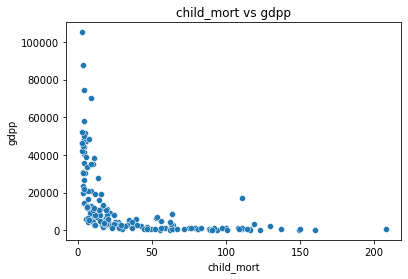

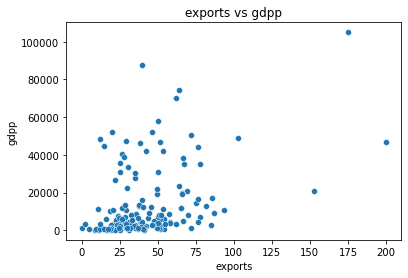

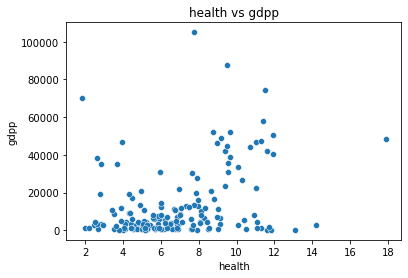

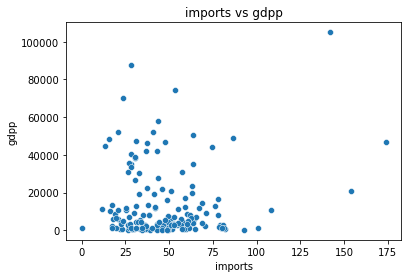

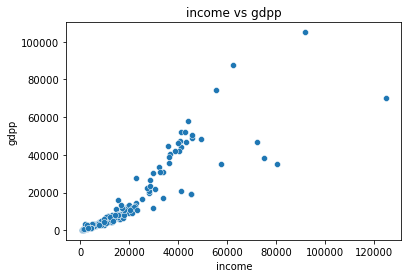

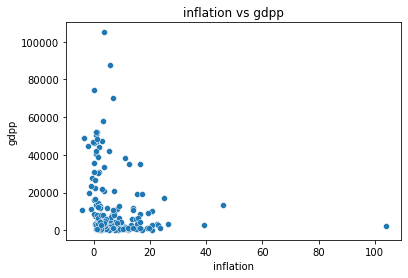

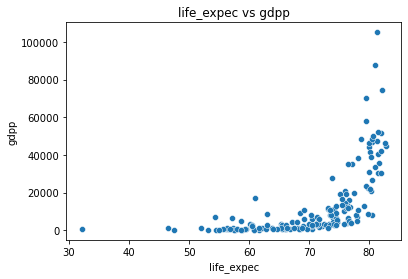

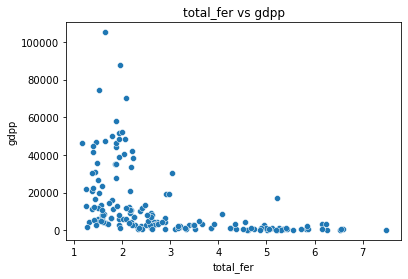

In [ ]:
# Explore the continuous independent features against gdpp using scatter plots.
for column in dataset.columns:
    if column != "gdpp":
        fig, ax = plt.subplots(1, 1)
        sns.scatterplot(data=dataset, x=column, y="gdpp")
        plt.xlabel(column)
        plt.ylabel("gdpp")
        plt.title("{} vs gdpp".format(column))
        plt.show()

By observing each pair plots of independent features vs 'gdpp', the existance of outliers in some of the features becomes easier to detect. 

The outliers might have a negative impact on the distribution of the data points and the way the relation between the feature and the 'gdpp' is depicted.

For this reason, it would be worth it to look at the pair plots after removing the outliers among the data points. 

In [371]:
# Removing the outliers
# https://www.geeksforgeeks.org/winsorization/

winsorized_data = pd.DataFrame(columns=dataset.columns)
# Winsorizing each column separately
# I decided on the threshold by constantly runing the winsorization and plotting the data, trying to tune them in a way that the distribution wouldn't get affected seriously.
for column in dataset.columns:
    WinsorizedArray = winsorize(dataset[column], (0.01, 0.06))
    winsorized_series = pd.Series(WinsorizedArray)
    winsorized_data[column] = winsorized_series

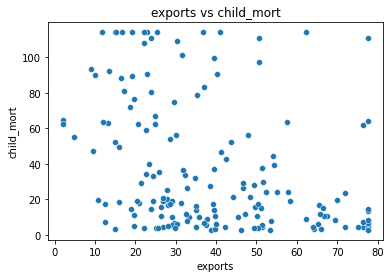

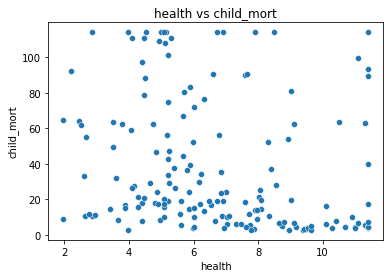

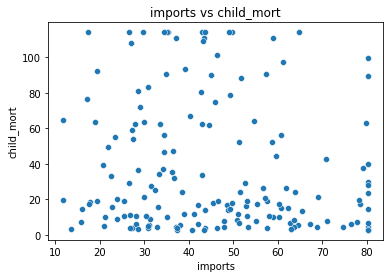

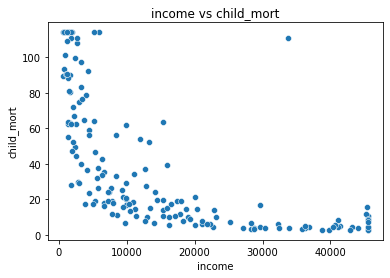

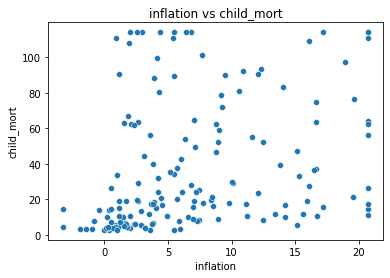

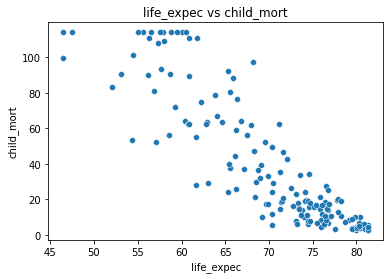

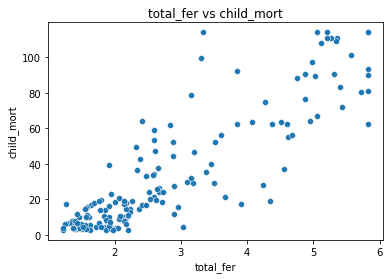

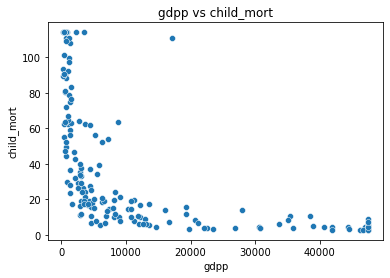

In [372]:
# Explore the continuous independent features against child_mort using scatter plots.
for column in dataset.columns:
    if column != "child_mort":
        fig, ax = plt.subplots(1, 1)
        sns.scatterplot(data=winsorized_data, x=column, y="child_mort")
        plt.xlabel(column)
        plt.ylabel("child_mort")
        plt.title("{} vs child_mort".format(column))
        plt.show()

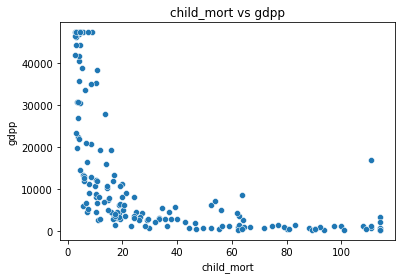

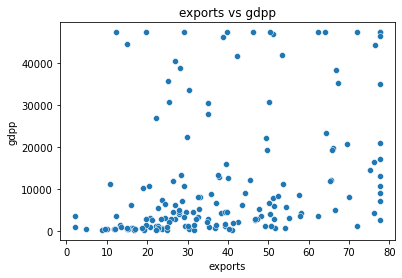

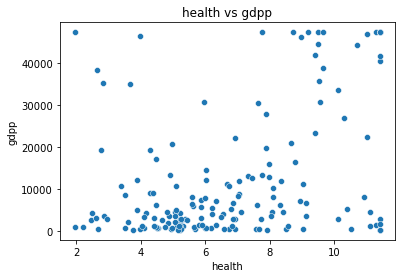

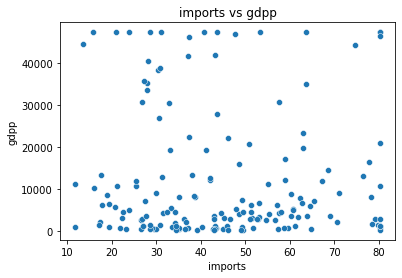

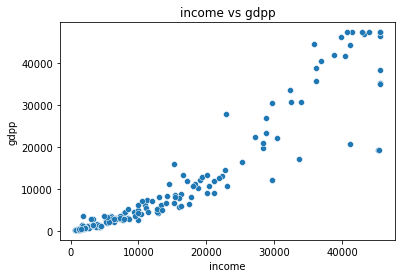

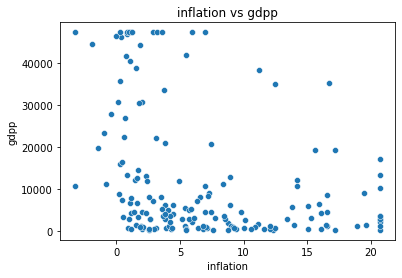

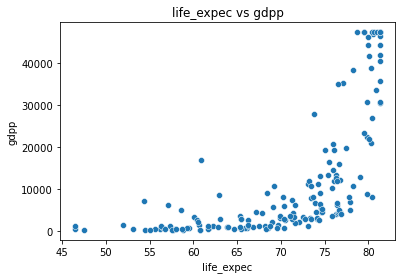

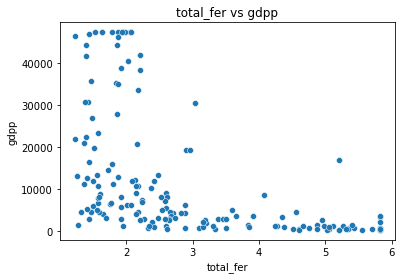

In [373]:
# Explore the continuous independent features against gdpp using scatter plots.
for column in dataset.columns:
    if column != "gdpp":
        fig, ax = plt.subplots(1, 1)
        sns.scatterplot(data=winsorized_data, x=column, y="gdpp")
        plt.xlabel(column)
        plt.ylabel("gdpp")
        plt.title("{} vs gdpp".format(column))
        plt.show()

After winsorizing the features and plotting them against 'gdpp', it comes to attention that some features like 'exports', 'imports' and 'health' scattered almost all over the plot, and well defined borders or in other words distinguished clusters are hardly detectable between groups of data points. 

Amongst the features, I chose the 'income' feature to use against 'gdpp' for clustering the data points. 

It was earlier discovered that this feature is the most correlated to the 'gdpp' out of other features, and it is easier to detect three separate clusters by looking at their pair plot.


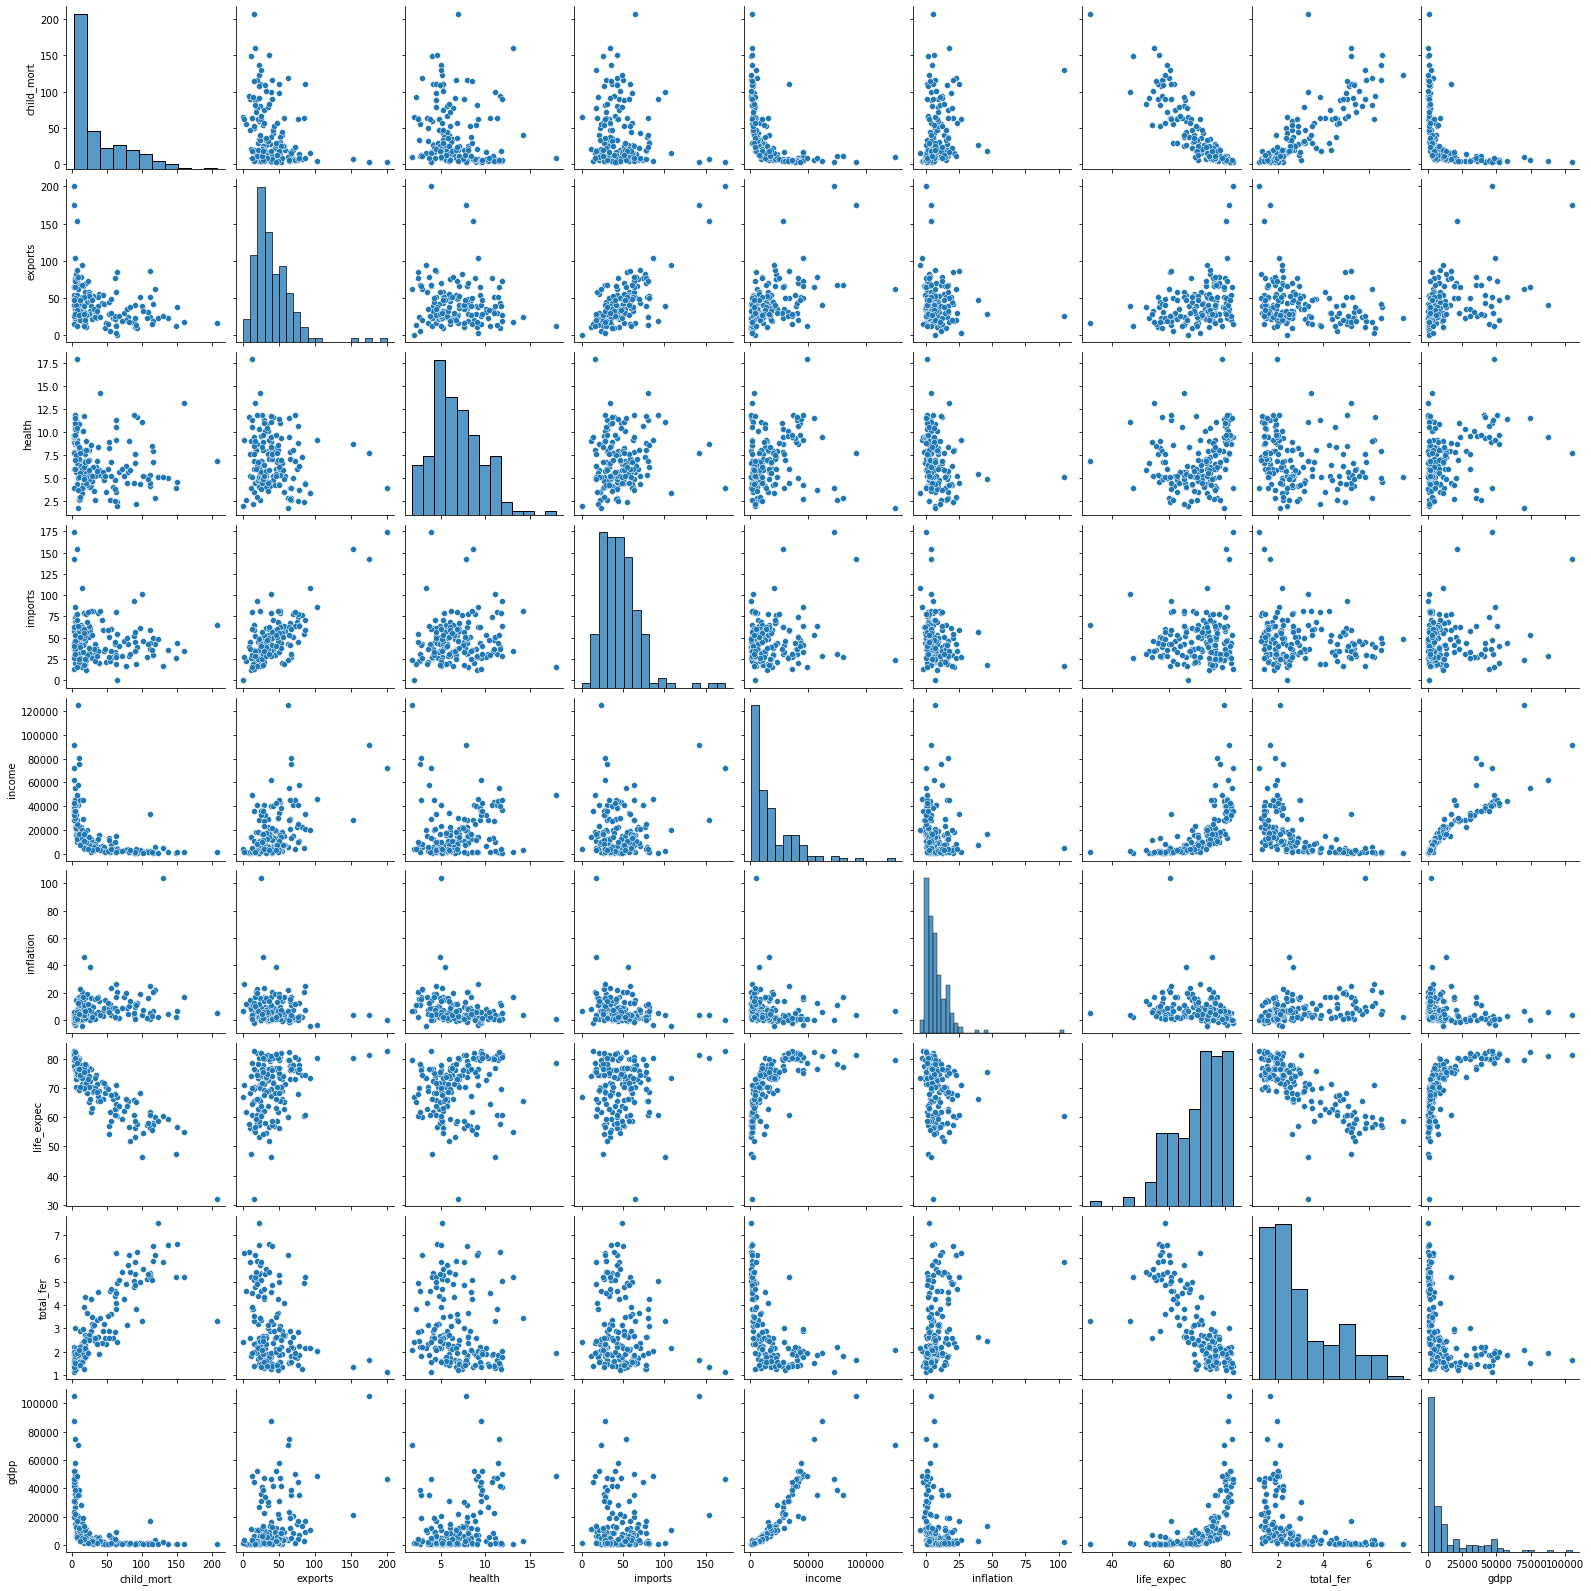

In [255]:
# Create a pair plot
# Hint: Explore seaborn pairplot

sns.pairplot(data=dataset)

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [374]:
# Removing the outliers
# https://www.geeksforgeeks.org/winsorization/

winsorized_data = pd.DataFrame(columns=dataset.columns)

for column in dataset.columns:
    WinsorizedArray = winsorize(dataset[column], (0.01, 0.06))
    winsorized_series = pd.Series(WinsorizedArray)
    winsorized_data[column] = winsorized_series

In [375]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

sc = MinMaxScaler()

df_scaled = sc.fit_transform(winsorized_data)
# https://www.geeksforgeeks.org/how-to-scale-pandas-dataframe-columns/
df_scaled = pd.DataFrame(df_scaled, columns=winsorized_data.columns)


df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.785971,0.103448,0.594910,0.483918,0.020312,0.529264,0.278736,1.000000,0.004801
1,0.124101,0.342175,0.485684,0.538012,0.206027,0.322324,0.856322,0.091503,0.079940
2,0.220324,0.480106,0.233298,0.286550,0.272321,0.807692,0.862069,0.361656,0.087800
3,1.000000,0.797082,0.093319,0.454678,0.116071,1.000000,0.390805,1.000000,0.068043
4,0.067446,0.574271,0.430541,0.688596,0.410714,0.194816,0.870690,0.196078,0.252225


## K-Means Clustering

### Selecting K

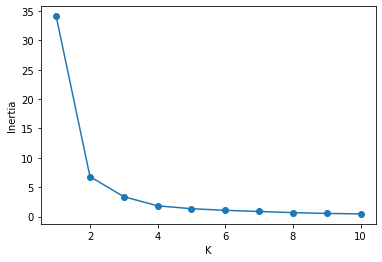

In [376]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_


def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k + 1)]
    plt.plot(range(1, 11), within_cluster_vars, marker="o")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.show()


# Plot elbow curve using scaled dataset
X = df_scaled[["income", "gdpp"]].values.reshape(-1, 2)

elbow_Kmeans(X)

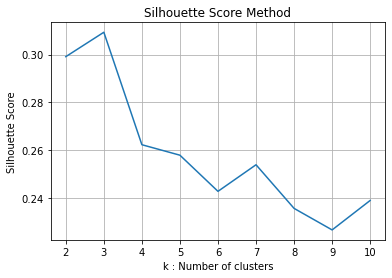

In [377]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric="euclidean"))

sns.lineplot(x=range(2, kmax + 1), y=sil)
plt.title("Silhouette Score Method")
plt.xlabel("k : Number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

As expected, 3 clusters fits the data better compared to the other numbers of clusters.

## Fitting a K-Means Model with the selected K value

In [378]:
# Remember to set the random_state to rseed
# Check model performance with the silhouette coefficient
kmeans = KMeans(n_clusters=3, random_state=rseed, max_iter=500)
kmeans.fit(df_scaled)
labels = kmeans.labels_
print(
    "The silhouette score of the selected K = 3: {}".format(
        silhouette_score(df_scaled, labels, metric="euclidean")
    )
)

The silhouette score of the selected K = 3: 0.30933403315582286


In [379]:
# Count the number of records in each cluster
# https://stackoverflow.com/questions/42916330/efficiently-count-zero-elements-in-numpy-array
cluster0_count = np.count_nonzero(labels == 0)
cluster1_count = np.count_nonzero(labels == 1)
cluster2_count = np.count_nonzero(labels == 2)

print("The number of records in cluster #0: {}".format(cluster0_count))
print("The number of records in cluster #1: {}".format(cluster1_count))
print("The number of records in cluster #2: {}".format(cluster2_count))

The number of records in cluster #0: 82
The number of records in cluster #1: 46
The number of records in cluster #2: 39


## Predictions

In [380]:
# Add the predicted cluster label column to the original dataframe
# https://www.geeksforgeeks.org/convert-a-numpy-array-to-a-pandas-series/
cluster_label_series = pd.Series(labels)

df_scaled["cluster_label"] = cluster_label_series

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label
0,0.785971,0.103448,0.594910,0.483918,0.020312,0.529264,0.278736,1.000000,0.004801,1
1,0.124101,0.342175,0.485684,0.538012,0.206027,0.322324,0.856322,0.091503,0.079940,0
2,0.220324,0.480106,0.233298,0.286550,0.272321,0.807692,0.862069,0.361656,0.087800,0
3,1.000000,0.797082,0.093319,0.454678,0.116071,1.000000,0.390805,1.000000,0.068043,1
4,0.067446,0.574271,0.430541,0.688596,0.410714,0.194816,0.870690,0.196078,0.252225,0


## Visualisation of clusters

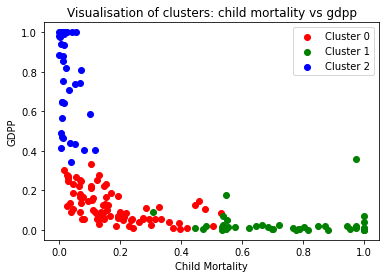

In [365]:
# Visualisation of clusters: child mortality vs gdpp
colors = "rgb"
for cluster in range(3):
    plt.scatter(
        df_scaled.loc[df_scaled["cluster_label"] == cluster].child_mort,
        df_scaled.loc[df_scaled["cluster_label"] == cluster].gdpp,
        c=colors[cluster],
        label="Cluster {}".format(cluster),
    )

plt.title("Visualisation of clusters: child mortality vs gdpp")
plt.xlabel("Child Mortality")
plt.ylabel("GDPP")
plt.legend()
plt.show()

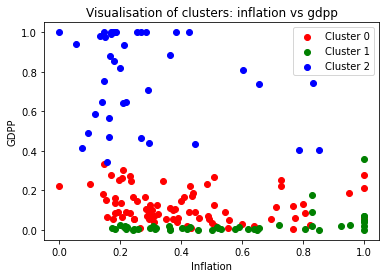

In [366]:
# Visualisation of clusters: inflation vs gdpp
colors = "rgb"
for cluster in range(3):
    plt.scatter(
        df_scaled.loc[df_scaled["cluster_label"] == cluster].inflation,
        df_scaled.loc[df_scaled["cluster_label"] == cluster].gdpp,
        c=colors[cluster],
        label="Cluster {}".format(cluster),
    )

plt.title("Visualisation of clusters: inflation vs gdpp")
plt.xlabel("Inflation")
plt.ylabel("GDPP")
plt.legend()
plt.show()

## Conclusions

Based on both plots, the data points belonging to the blue colored cluster (Cluster #2) have higher GDPP compared to the other two clusters. This can mean that these countries have a more stable and healthy economy based on their high GDPs. These countries can be labelled as **developed countries**, judging by the high GDPs. 
It is to justify this assumption by observing the clusters in the 'child mortality vs GDPP' plot. The blue cluster is located in the higher end of the GDPP spectrum with the small records of the child mortality, which could be a result of a healthy economy, with good quality of life style and public services to the people hence higher support for the health services and supervision to the children. These all would lead to the lower child death rate in those countries. Looking at the 'inflation vs GDPP' plot, the majority of developed countries are standing on the lower side of the inflation rate and even the largest inflation rate from this cluster is lower than the ones from the other two clusters. This could be again another side effect of the healthy and stable economy which keeps the inflation's negative under control.

Moving forward to the green cluster (Cluster #1), where the data points belonging to this cluster mostly have lowest GDPs recorded. This is a sign of weak and struggling economy, where the money circulation is not as rapid and huge as it needs to be and it puts the country in a critical situation. Looking at the 'child mortality vs GDPP', the countries assigned to this cluster, have the highest child mortality rate recorded. This could be a natural consequence of the unstable economy, with harder life style, and a health system suffering from low fundings, which leads to less support or people not being able to afford for the medical services. These countries could be labelled as **least developed** countries. The inflation rates of these countries are amongst the highest as a good number of them are on the higher side of the inflation spectrum. Based on the last resource mentioned at the end, the higher the inflation rate, the lower the GDP growth would be. And as the GDP doesn't grow, the economy of the country will continue to struggle.

And the last cluster is the red cluster (Cluster #0) with the most number of data points, located between two previous clusters in both plots. The countries belonging to this cluster have GDPs lower than the developed countries and higher than the least developed countries. This cluster can be labelled as **developing** countries. They are currently in a state with a GDP not too high, which could be sign of an economy in developing process. And their child mortality rate starts from the least rate and ends at the avergae rate which again could be related to the fact that their economy is healing and improving. This would lead to gaining a better control over the situation in side the borders of those countries, with an improving health service as an example. The developing countries are more focused around the lower to mid section of the inflation rate, again somewhere not as safe as the developed countries nor as critical as the least developed countries.

Resources: 

- https://en.wikipedia.org/wiki/Gross_domestic_product#:~:text=Gross%20Domestic%20Product%20(GDP)%20is,of%20a%20country%20or%20region.
- https://en.wikipedia.org/wiki/Developed_country
- https://www.tutor2u.net/economics/reference/benefits-and-costs-of-high-inflation-for-a-government#:~:text=High%20inflation%20can%20cause%20GDP,making%20government%20borrowing%20more%20expensive